# Data Analysis for IFAC 2017

This notebook imports data from the ../tests/data directory and must be redirected if the directory has moved.

### Manual performance data

Let's construct some box plots with material moved per cycle and material moved per cycle time.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Manually copy data from 'manual_trials.xlsx'

In [3]:
mitch = [22.13, 10.4, 56.28, 17.24, 26.29]
shyam = [20.425, 16.05, 69.625, 19.66153846, 121.6666667]

# Below is FAKE data for placeholders
orlando = np.random.normal(40, 20, 15)
yalen = np.random.normal(30, 10, 15)

In [4]:
data =[mitch, shyam, orlando, yalen]

# May instead use mass per second, so that big number is good.
data_inv = [[1/pt for pt in trial] for trial in data]

labels = ['Manual Op. 1', 'Manual Op. 2', 'Manual Op. 3', 'Manual Op. 4']

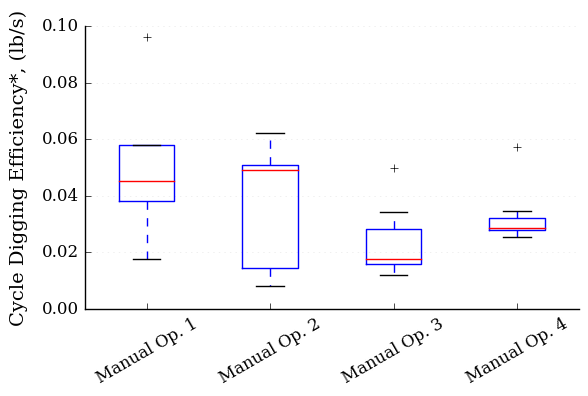

In [5]:
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=12)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=12)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on a horizontal grid and set appropriate linestyle and color
ax.yaxis.grid(True, linestyle=':', which='major', color='lightgrey',
               alpha=0.5)
ax.set_axisbelow(True)

# Define the X and Y axis labels
# plt.xlabel('Operators and Control Architecture', family='serif', fontsize=14, labelpad=5)
plt.ylabel('Cycle Digging Efficiency*, (lb/s)', family='serif', fontsize=14, labelpad=10)

plt.boxplot(data_inv)
plt.xticks(range(1, 5),labels, rotation=30)

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax.yaxis.grid(True, linestyle=':', which='major', color='lightgrey',
               alpha=0.5)

# plt.xlabel('')
# plt.ylabel('Time per unit mass of material moved during one cycle, (s/lb)')

plt.tight_layout()
plt.savefig('box_plot.pdf', dpi=600)
plt.show()



# Trial Data for Each Actuator

Let's look at the measurement data from each actuator for several different types of runs.

In [14]:
cd ../tests/data/

/Users/mitchallain/Development/Python/BeagleBone-excavator/tests/data


In [15]:
import pandas as pd
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})

In [16]:
# Import the manual, autonomous, and blended data

manual = pd.read_csv('manual_1021_mitch.csv')
autonomous = pd.read_csv('autonomous_1024_1959.csv')
blended = pd.read_csv('blended_shyam_1102_1902.csv')

In [17]:
cd ../../ipython\ notebooks

/Users/mitchallain/Development/Python/BeagleBone-excavator/ipython notebooks


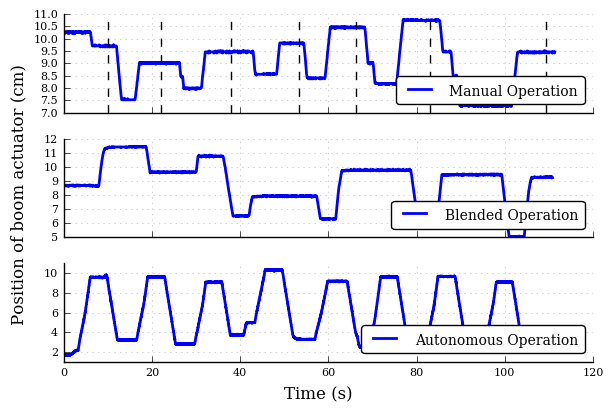

In [18]:
# Set the plot size - 3x2 aspect ratio is best
# Three subplots, one for each control mode
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 4))

for i in range(3):
    # Change the axis units to serif
    plt.setp(ax[i].get_ymajorticklabels(), family='serif', fontsize=8)
    plt.setp(ax[i].get_xmajorticklabels(), family='serif', fontsize=8)
    
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')

    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')

    # Turn on the plot grid and set appropriate linestyle and color
    ax[i].grid(True,linestyle=':', color='0.75')
    ax[i].set_axisbelow(True)

ax[0].plot(manual['Time'][:15000], manual['Boom Ms'][:15000], linewidth=2, linestyle='-', label=r'Manual Operation')

# Create markers for cycle width
manual_end_cycle = [10.02, 22.13, 37.99, 53.3, 66.32, 83.11, 109.4]
# blend_end_cycle = []
for pt in manual_end_cycle:
    ax[0].plot((pt, pt), (7, 11), 'k--')

ax[1].plot(blended['Time'][:2100], blended['Stick Ms'][:2100], linewidth=2, linestyle='-', label=r'Blended Operation')

ax[2].plot(autonomous['Time'][:15000], autonomous['Bucket Ms'][:15000], linewidth=2, linestyle='-', label=r'Autonomous Operation')

# Create the legend, then fix the fontsize
for i in range(3):
    leg = ax[i].legend(loc='lower right', ncol = 1, fancybox=True)
    ltext = leg.get_texts()
    plt.setp(ltext, family='serif', fontsize=10)

plt.gcf().subplots_adjust(bottom=0.5, left = 0.5)
    
# Set common labels
fig.text(0.5, 0, 'Time (s)', ha='center', va='center', family='serif', fontsize=12)
fig.text(0, 0.5, 'Position of boom actuator (cm)', ha='center', va='center', fontsize=12, family='serif', rotation='vertical')


# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout()

# plt.show()
# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
plt.savefig('BoomComparison.pdf')

# fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

# Opposition Metric

This portion will use the blending data imported above and compute the opposition of the human and controller input.

### Preparing the data

Let's erase the controller output while assistance is inactive, and saturate the control action at [-1, 1] (it is saturated in the control code).

In [19]:
# Erase all control action when assistance is not active
# Saturate control action at [-1, 1] (may already be done in software)
for i in range(len(blended)):
    if blended['Confidence'][i] == False:
        for col in ['Boom Ctrl', 'Stick Ctrl', 'Bucket Ctrl', 'Swing Ctrl']:
            blended.loc[i, col] = 0
    elif blended['Confidence'][i] == True:
        for col in ['Boom Ctrl', 'Stick Ctrl', 'Bucket Ctrl', 'Swing Ctrl']:
            if abs(blended[col][i]) > 1:
                blended.loc[i, col] = max(-1, min(1, blended[col][i]))

### Visualizing the data

We will plot the control action to check the above data processing, compute the difference between controller output and human command, and finally smooth this difference for visualization.

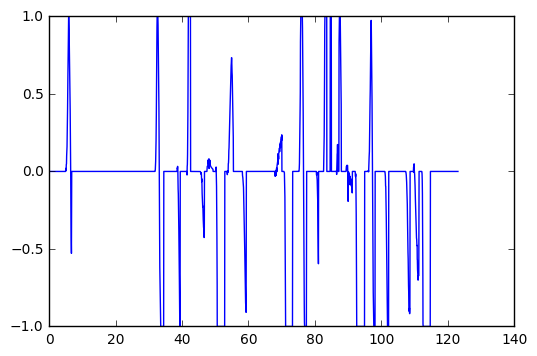

In [20]:
plt.plot(blended['Time'], blended['Bucket Ctrl'])

In [21]:
blended['Confidence'].as_matrix().astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
bm_opp = blended['Boom Ctrl'].subtract(blended['Boom Cmd']).abs().as_matrix()
bm_opp = np.multiply(bm_opp, blended['Confidence'].as_matrix().astype(int))

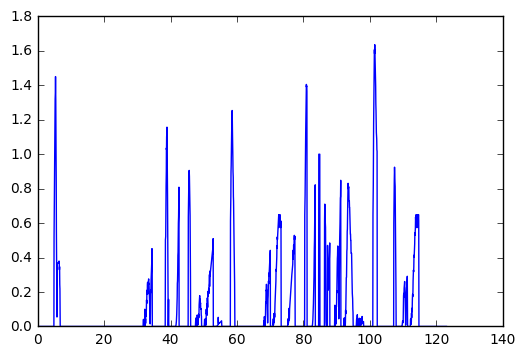

In [23]:
plt.plot(blended['Time'], bm_opp)

## Smoothing function

See http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

In [24]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [25]:
window_size = 80
bm_opp_sm = smooth(bm_opp, window_size)
st = (window_size / 2) - 1
sp = -(window_size / 2)
# plt.plot(blended['Time'], bm_opp)

In [26]:
len(bm_opp_sm[st:sp]), len(blended['Time'])

(2331, 2331)

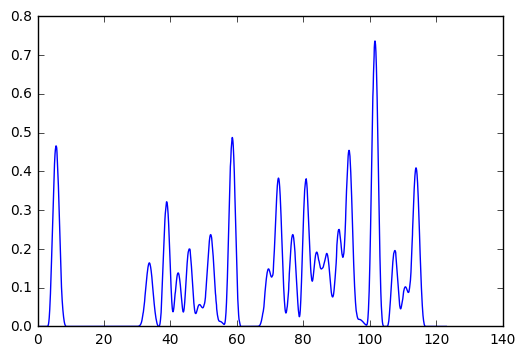

In [27]:
plt.plot(blended['Time'].as_matrix(), bm_opp_sm[st:sp])

## Summing opposition over the cycle

Sum the opposition over each cycle using 'blended_end_cycle' defined previously. 

In [31]:
opp = bm_opp.sum() / blended['Time'][2330]
opp

2.0654216944945687

In [33]:
np.trapz(bm_opp, blended['Time'].as_matrix())/blended['Time'][2330]

0.11067970797548218

## Trying something out

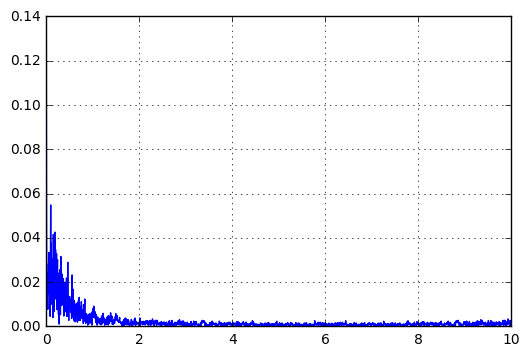

In [34]:
from scipy.fftpack import fft
oppf = fft(bm_opp)
T = 0.05
N = 3820
wf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.plot(wf, 2.0/N*np.abs(oppf[0:N/2]))
plt.grid()
plt.show()